https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/

https://docs.gimp.org/en/plug-in-convmatrix.html

In [2]:
# Package imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [20]:
# matrix_1 = np.array([
#     [1, 1, 1, 0, 0],
#     [0, 1, 1, 1, 0],
#     [0, 0, 1, 1, 1],
#     [0, 0, 1, 1, 0],
#     [0, 1, 1, 0, 0]
# ])

matrix_1 = np.array([
    [1, 1, 1, 0, 0, 1],
    [0, 1, 1, 1, 0, 1],
    [0, 0, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 0, 0],
])

matrix_2 = np.array([
    [1, 0, 1],
    [0, 1, 0],
    [1, 0, 1],
])

filter_sharpen = np.array([[
    [ 0,-1, 0],
    [-1, 5,-1],
    [ 0,-1, 0],
]])

edge_detect = np.array([
    [0, 1, 0],
    [1,-4, 1],
    [0, 1, 0],
])


def convolution(matrix, screen, stride):
    
    window_width = matrix.shape[0]
    screen_width = screen.shape[0]
    
    matrix_output = np.zeros(((window_width-2)/2,(window_width-2)/2))
    
    for i in range(0, window_width-2, stride):
        for j in range(0, window_width-2, stride):
            window = matrix[i:i+screen_width,j:j+screen_width]
            combined = screen * window
            matrix_output[i/2][j/2] = combined.sum()

    return matrix_output


In [44]:
pm = 2

# m_3 = matrix_3.shape[0]

# m_4 = m_3 / pm

pooled = np.zeros((2,2))

for i in range(2):
    for j in range(2):
        window = matrix_3[2*i:2*i+2,2*j:2*j+2]
#         print window
        pooled[i][j] = np.sum(window)
        
print pooled



[[ 13.  13.]
 [ 11.   9.]]


In [233]:

def predict_2(X, thetas):
    a = X
    thetas_len = len(thetas)
    for i, theta in enumerate(thetas):
        b = theta[0:1]
        w = theta[1:]
        z = np.dot(a, w) + b

        if i < thetas_len-1:
            a = np.tanh(z)
        else:
            exp_scores = np.exp(z)
            a = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
#     print 'a', a
    return np.argmax(a, axis=1)

def calculate_loss_2(X, y, thetas, reg_lambda):
    m = X.shape[0]
    a = X
    thetas_len = len(thetas)

    for i, theta in enumerate(thetas):
        b = theta[0:1]
        w = theta[1:]
        z = np.dot(a, w) + b

        if i < thetas_len-1:
            a = np.tanh(z)
        else:
            exp_scores = np.exp(z)
            a = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    correct_logprobs = -np.log(a[range(m), y.ravel()])
    data_loss = np.sum(correct_logprobs)
    
    weights_sum = 0
    for theta in thetas:
        w = theta[1:]
        w_sq = np.square(w)
        w_sq_sum = w_sq.sum()
        weights_sum += w_sq_sum
    reg = (reg_lambda/2) * weights_sum
    return 1./m * (data_loss + reg)



def compute_gradient_2(X, y, thetas, reg_lambda):
    m = X.shape[0]
    a = X
    thetas_len = len(thetas)

    activations = [X]
    
    for i, theta in enumerate(thetas):
        b = theta[0:1]
        w = theta[1:]
        z = np.dot(a, w) + b

        if i < thetas_len-1:
            a = np.tanh(z)
        else:
            exp_scores = np.exp(z)
            a = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        activations.append(a)

    deltas = [None] * thetas_len
    
    for i in range(thetas_len-1,-1,-1):
        if i == thetas_len-1:
            delta = activations[i+1]
            delta[range(m), y.ravel()] -= 1
        else:
            next_delta = deltas[i+1]
            next_theta = thetas[i+1]
            next_w = next_theta[1:]
            a = activations[i+1]
            delta = np.dot(next_delta, next_w.T) * (1 - np.power(a, 2))
        deltas[i] = delta
    
    thetas_grad = []
    for i in range(len(deltas)):
        delta = deltas[i]
        theta = thetas[i]
        w = theta[1:]
        a = activations[i]
        
        b_grad = np.sum(delta, axis=0, keepdims=True)
        w_grad = np.dot(a.T, delta) + reg_lambda * w
        theta_grad = np.vstack((b_grad, w_grad))
        thetas_grad.append(theta_grad)
    
    return thetas_grad


def gradient_descent(X, y, reg_lambda, alpha, layers, num_iters):    
    
    rand = np.random.RandomState(12)
    
    thetas = []
    for i in range(len(layers)-1):
    
        mm = layers[i]
        nn = layers[i+1]
        theta = rand.rand(mm+1, nn) / np.sqrt(mm)
        theta[0] = 0
        thetas.append(theta)
    
    costs = []
    for i in range(num_iters):
        
        if i % 1 == 0:
            cost = calculate_loss_2(X, y, thetas, reg_lambda)
            costs.append(cost)
        
        thetas_grad = compute_gradient_2(X, y, thetas, reg_lambda)
    
        for i, theta_grad in enumerate(thetas_grad):
            thetas[i] -= alpha * theta_grad

    return thetas, costs


def do_prediction(X, y, thetas):
    m = X.shape[0]
    predicted = predict_2(X, thetas).reshape(m,1)
    n_correct = (predicted == y).sum()
    percent_correct = float(n_correct) / m
    return percent_correct


In [46]:
X = np.array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         54, 227, 253, 252, 239, 233, 252,  57,   6,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  10,  60,
        224, 252, 253, 252, 202,  84, 252, 253, 122,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 163, 252,
        252, 252, 253, 252, 252,  96, 189, 253, 167,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  51, 238, 253,
        253, 190, 114, 253, 228,  47,  79, 255, 168,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  48, 238, 252, 252,
        179,  12,  75, 121,  21,   0,   0, 253, 243,  50,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  38, 165, 253, 233, 208,
         84,   0,   0,   0,   0,   0,   0, 253, 252, 165,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   7, 178, 252, 240,  71,  19,
         28,   0,   0,   0,   0,   0,   0, 253, 252, 195,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  57, 252, 252,  63,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 253, 252, 195,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 198, 253, 190,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 255, 253, 196,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  76, 246, 252, 112,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 253, 252, 148,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 230,  25,   0,   0,   0,
          0,   0,   0,   0,   0,   7, 135, 253, 186,  12,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 223,   0,   0,   0,   0,
          0,   0,   0,   0,   7, 131, 252, 225,  71,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 145,   0,   0,   0,   0,
          0,   0,   0,  48, 165, 252, 173,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  86, 253, 225,   0,   0,   0,   0,
          0,   0, 114, 238, 253, 162,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 249, 146,  48,  29,  85,
        178, 225, 253, 223, 167,  56,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 252, 252, 229, 215, 252,
        252, 252, 196, 130,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  28, 199, 252, 252, 253, 252, 252,
        233, 145,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  25, 128, 252, 253, 252, 141,
         37,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])

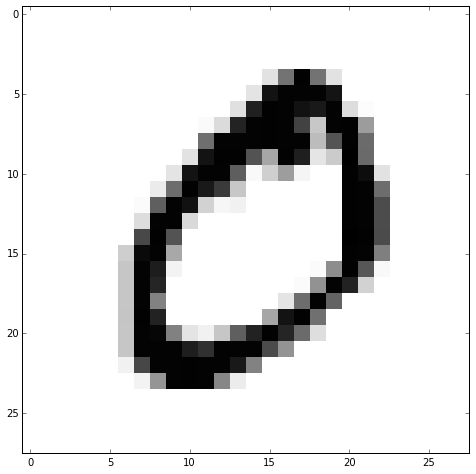

In [54]:
plt.imshow(np.reshape(X, [28,28]), cmap='Greys', interpolation='nearest')

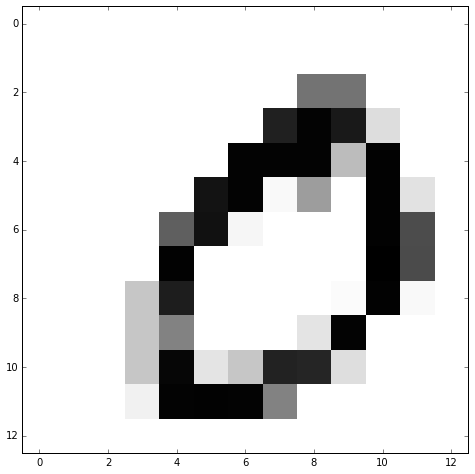

In [106]:
conv_sharp = convolution(np.reshape(X, [28, 28]), filter_sharpen, 2)
plt.imshow(conv_edge, cmap='Greys', interpolation='nearest')

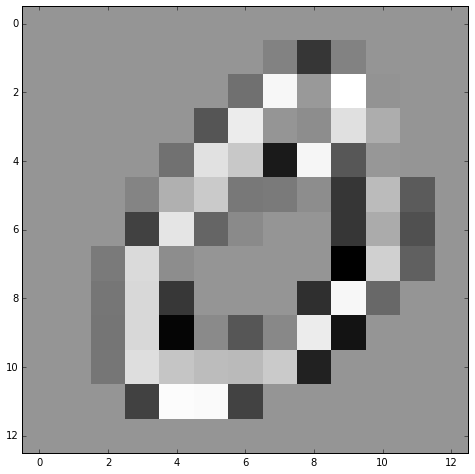

In [107]:
conv_edge = convolution(np.reshape(X, [28, 28]), edge_detect, 2)
plt.imshow(conv_edge, cmap='Greys', interpolation='nearest')

In [168]:
# print conv_edge.shape[0]/2

def pooling(original_matrix, pool_size, method):
    m = original_matrix.shape[0]
    
    num_of_stride = m / pool_size
    
    pool_matrix = np.zeros((num_of_stride, num_of_stride))
    for i in range(num_of_stride):
        i1 = i * pool_size
        i2 = i * pool_size + pool_size
        for j in range(num_of_stride):
            j1 = j * pool_size
            j2 = j * pool_size + pool_size
            
            pool = original_matrix[i1:i2,j1:j2]
            pool_matrix[i][j] = method(pool)
    return pool_matrix

pool_matrix = pooling(conv_edge, 2, np.sum)
print pool_matrix.shape
plt.imshow(pool_matrix, cmap='Greys', interpolation='nearest')


NameError: name 'conv_edge' is not defined

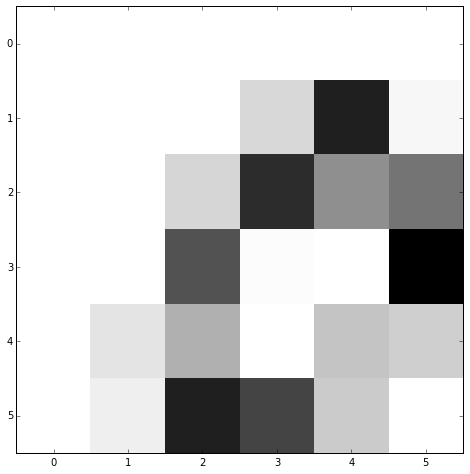

In [110]:
pool_sharp = pooling(conv_sharp, 2, np.sum)
plt.imshow(pool_sharp, cmap='Greys', interpolation='nearest')

In [3]:
df = pd.read_csv('../mnist/mnist_train.csv')

In [273]:

def feature_normalize(X):
    mean = np.mean(X)
    std = np.std(X, ddof=1)
    return ( X - mean ) / std

matrix = df.as_matrix()[:5000]
m = matrix.shape[0]
y = matrix[:,0:1]
X = matrix[:,1:]

X = feature_normalize(X)


In [274]:
# plt.imshow(np.reshape(X[0], [28,28]), cmap='Greys', interpolation='nearest')
# conv_sharp = convolution(np.reshape(X, [28, 28]), filter_sharpen, 2)

# print 'X.shape', X.shape

# def my_func(x):
#     return convolution(np.reshape(x, [28, 28]), filter_sharpen, 2)
# #     return np.sum(x)

# np.apply_along_axis(my_func, axis=1, arr=X)

# convolution(np.reshape(X[0], [28, 28]), filter_sharpen, 2)

# conv_1 = np.zeros()
m = X.shape[0]
conv_1 = np.empty((m,72), dtype=np.float64)
for i, x in enumerate(X):
    convoluted_1 = convolution(np.reshape(x, [28, 28]), filter_sharpen, 2)
    relu_1 = np.maximum(convoluted_1, 0)
    pool_1 = pooling(relu_1, 2, np.sum)
    
    convoluted_2 = convolution(np.reshape(x, [28, 28]), edge_detect, 2)
    relu_2 = np.maximum(convoluted_2, 0)
    pool_2 = pooling(relu_2, 2, np.max)

    conv_1[i] = np.concatenate((pool_1, pool_2), axis=1).reshape(72)


print conv_1.shape
# print conv_1[0].shape

# plt.imshow(conv_1[2], cmap='Greys', interpolation='nearest')

(5000, 72)


In [ ]:
alpha = 0.0003
reg_lambda = 0.001

layers = [72,12,8,10]
num_iters = 5000

thetas, costs = gradient_descent(conv_1, y, reg_lambda, alpha, layers, num_iters)

print do_prediction(conv_1, y, thetas)
    
plt.plot(costs)
